# UDACITY - Project 2 - Continuous Control

---


## 1. Start the Environment on UDACITY workplace

Run the next code cell to install a few packages on the UDACITY workspace.  This line will take a few minutes to run! It's not required if you run this notebook on your computer, as the environment has been installed following the intructions of the README.

In [1]:
!pip -q install ./python

The environments corresponding to both versions REACHER are already saved in the UDACITY workspace and can be accessed using the file paths provided below. Please only use one of these at a time for loading the environment.

## 2. Mono Agent version of REACHER
### 2.1. Start the environment on UDACITY workplace


In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
# env = UnityEnvironment(file_name='Reacher.app')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
# env = UnityEnvironment(file_name='./20/Reacher.app')


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2.2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 2.3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


### 2.4. Train the agent

#### 2.4.1. The algorithm
As suggested, I decide to use the DDPG algorithm to solve this problem, and the code for the model ('model.py') and the agent ('agent.py') is higly inspired from: 
- https://github.com/udacity/deep-reinforcement-learning/blob/55474449a112fa72323f484c4b7a498c8dc84be1/ddpg-bipedal/model.py
- https://github.com/udacity/deep-reinforcement-learning/blob/55474449a112fa72323f484c4b7a498c8dc84be1/ddpg-bipedal/ddpg_agent.py
 
#### 2.4.2. The model
Both Actor & Critic are implemented using deep neural networks with 2 hidden layers. I have experimented various architecture: 
- fc1 = 256 & fc2 = 128
- fc1 = 400 & fc2 = 200
- fc1 = 200 & fc2 = 400
- fc1 = 128 & fc2 = 256

And it appears that the last one (fc1 = 128 & fc2 = 256) is converging better and faster.

As suggested in the Slack channel, I have tried to add a Batch Normalization layer after the first layer, but it didn't improve the convergence. It was also suggested to use leaky_relu instead of rely for the Critic neural network, but I didn't notice improvement.

#### 2.4.3. The hyper parameters
Convergence mainly came when I've started to tweak the hyper parameters:
- BUFFER_SIZE = int(2e6)
- BATCH_SIZE = 64
- GAMMA = 0.95
- TAU = 0.001
- LR_ACTOR = 0.001        
- LR_CRITIC = 0.0001
- WEIGHT_DECAY = 0   

Convergence suddenly came when I've started reducing GAMMA and increasing the learning rate of the Actor neural network. 

In [6]:
from collections import deque
import matplotlib.pyplot as plt

In [7]:
from agent import Agent

In [8]:
import torch

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=22)

In [10]:
def ddpg(n_episodes=200, max_t=1000, print_every=10):
    scores = []
    scores_deque = deque(maxlen=100)
    solved = False
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        
        for t in range(max_t):
            action = agent.act(state)          # select an action
       
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) # take step with agent (including learning)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:
                break 

        
        scores_deque.append(np.mean(score))       # save most recent score
        scores.append(np.mean(score))             # save most recent score

        print('\rEpisode #{}\tAverage Score = {:.2f}\tScore of this episode = {:.3f}'.format(i_episode, np.mean(scores_deque), score), end="")
            
        if i_episode % (print_every) == 0:
            print('\rEpisode #{}\tAverage Score = {:.2f}\tScore of this episode = {:.3f}'.format(i_episode, np.mean(scores_deque), score))
        
        if ((i_episode > 100) and (np.mean(scores_deque) >= 30.0) and (solved == False)):
            solved = True
            print('\nEnvironment solved in {:d} episodes !\tAverage Score = {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            # continue up to n_episodes to confirm the environment is really solved
            # break
            
    return scores

### 2.5. Plot and analyse the result

This environment is solved after 167 episodes (average on the last 100 rewards > 30), but start at 110 episodes, the reward remains above 30. To be 100% sure the reward do not fall down later, I continue the loop until 200 episodes.

Episode #10	Average Score = 1.27	Score of this episode = 1.020
Episode #20	Average Score = 0.91	Score of this episode = 1.500
Episode #30	Average Score = 1.48	Score of this episode = 3.390
Episode #40	Average Score = 1.77	Score of this episode = 2.900
Episode #50	Average Score = 2.25	Score of this episode = 3.970
Episode #60	Average Score = 2.90	Score of this episode = 6.600
Episode #70	Average Score = 3.61	Score of this episode = 9.4000
Episode #80	Average Score = 4.49	Score of this episode = 9.5700
Episode #90	Average Score = 5.75	Score of this episode = 18.080
Episode #100	Average Score = 7.35	Score of this episode = 27.540
Episode #110	Average Score = 10.43	Score of this episode = 32.760
Episode #120	Average Score = 14.02	Score of this episode = 37.500
Episode #130	Average Score = 17.63	Score of this episode = 38.370
Episode #140	Average Score = 21.19	Score of this episode = 38.010
Episode #150	Average Score = 24.59	Score of this episode = 36.340
Episode #160	Average Score = 27.87	

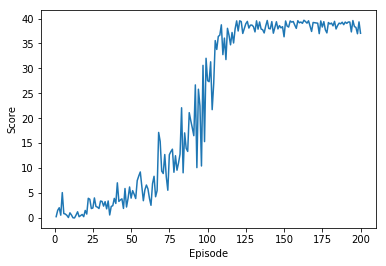

In [11]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [12]:
env.close()

## 3. Multi Agent version of REACHER
### 3.1. Start the environment on UDACITY workplace

In [2]:
from unityagents import UnityEnvironment
import numpy as np

In [3]:
# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
# env = UnityEnvironment(file_name='./20/Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 3.2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3.3. Train all the agents

We have kept:
- the same DDPG algorithm
- the same 128-256 neural network model for both Actor & Critic
- the same hyper parameters

as the mono agent version.

In [6]:
from collections import deque
import matplotlib.pyplot as plt
import torch
from multi_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=44)

In [7]:
def ddpg_ma(n_episodes=200, max_t=1000, print_every=10):
    scores = []
    scores_deque = deque(maxlen=100)
    solved = False
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations            # get the current state
        score = np.zeros(num_agents)
        
        for t in range(max_t):
            action = agent.act(state)          # select an action
       
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations   # get the next state
            reward = env_info.rewards                   # get the reward
            done = env_info.local_done                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) # take step with agent (including learning)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if np.any(done):
                break 

        
        scores_deque.append(np.mean(score))       # save most recent score
        scores.append(np.mean(score))             # save most recent score

        print('\rEpisode #{}\tAverage Score = {:.2f}\tScore of this episode = {:.3f}'.format(i_episode, np.mean(scores_deque), np.mean(score)), end="")
            
        if i_episode % (print_every) == 0:
            print('\rEpisode #{}\tAverage Score = {:.2f}\tScore of this episode = {:.3f}'.format(i_episode, np.mean(scores_deque), np.mean(score)))
        
        if ((i_episode > 100) and (np.mean(scores_deque) >= 30.0) and (solved == False)):
            solved = True
            print('\nMulti-agent Environment solved in {:d} episodes !\tAverage Score = {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'ma-checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'ma-checkpoint_critic.pth')
            # continue up to n_episodes to confirm the environment is really solved
            # break
            
    return scores

### 3.4. Plot and analyse the result

This environment is solved only after 111 episodes (average on the last 100 rewards > 30), but starts at 50 episodes, the reward remains above 30. To be 100% sure the reward do not fall down later, I continue the loop until 200 episodes.

The multi agent converges faster than the mono agent, because it benefits from 20 times more experiences at each episode.

Episode #10	Average Score = 0.70	Score of this episode = 1.639
Episode #20	Average Score = 1.56	Score of this episode = 3.027
Episode #30	Average Score = 3.25	Score of this episode = 10.207
Episode #40	Average Score = 8.09	Score of this episode = 29.864
Episode #50	Average Score = 13.70	Score of this episode = 38.088
Episode #60	Average Score = 17.83	Score of this episode = 38.681
Episode #70	Average Score = 20.80	Score of this episode = 38.632
Episode #80	Average Score = 23.05	Score of this episode = 38.738
Episode #90	Average Score = 24.78	Score of this episode = 38.430
Episode #100	Average Score = 26.16	Score of this episode = 38.232
Episode #110	Average Score = 29.95	Score of this episode = 38.357
Episode #111	Average Score = 30.33	Score of this episode = 39.183
Multi-agent Environment solved in 111 episodes !	Average Score = 30.33
Episode #120	Average Score = 33.59	Score of this episode = 39.261
Episode #130	Average Score = 36.81	Score of this episode = 39.034
Episode #140	Average

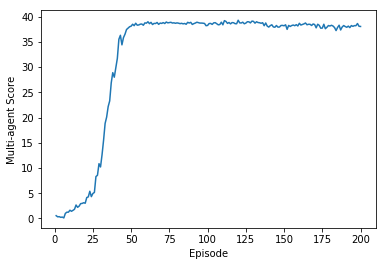

In [8]:
scores = ddpg_ma()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Multi-agent Score')
plt.xlabel('Episode')
plt.show()

In [9]:
env.close()

## 4. Future work

I've focussed on DDPG but there are DDPG improvements to try, such as D3PG and D4PG, A3C and PPO:
- In the Slack channel, some students have reported great results using PPO instead of DDPG. 
- In this paper written by [Barth-Maron et al 2018](https://openreview.net/forum?id=SyZipzbCb) D4PG has achieved state of the art results on continuous control problems.


However there is still room for improvement on the DDPG algorithm:
- use priority in the Replay Buffer 
- adjust the Ornstein-Uhlenbeck noise level